# SP+ End-to-end Evaluation: Annotation

## 0. Setting up your environment
0a.) Install spp client to your local device: pip install -i https://pip.s2.allenai.org/simple spp_client.      
0b.) Download json files from s3://ai2-s2-mmda/citation-link-evaluation-sample/ for Grobid data.

## 1. Get data from annotation store via spp_client

### 1a. Get and set sources
Retreive information about the sources for each annotation - mentions, bib-entries, bib-entry-parses, and pdf plumber

In [1]:
#Sources for Eval Sample
mention_detection_source = "citation_mentions-0.0.test1|pdfplumber-0.0.6"
bib_mention_linker_source = "citation-links-0.0.test1|bib-entry-detector-0.0.test3|citation_mentions-0.0.test1|pdfplumber-0.0.6"
bib_detection_source = "bib-entry-detector-0.0.test3|vila-0.0.2|pdfplumber-0.0.6"
pdf_plumber = "pdfplumber-0.0.6"
bib_parsing_source ="bib_entry_predictor-0.0.test1|bib-entry-detector-0.0.test3|pdfplumber-0.0.6"

In [2]:
##################################
# ANNOTATOR TODO: change this to sha you're analyzing
##################################

#sha = '17ada3c96ef888fc89f6b995d2edd19a45383423'
#sha = '121e30c48546e671dc5e16c694c5e69b392cf8fb' 


#working
sha = '0309838ecb2e4b98f4ba0557a1034de2a4576db8'
#sha = '01713743a7fe67938b7f7a7b137711e03364d02d'

### 1b. Retrieve Annotations
Using the sources obtained from the previous cell, we will now retreive the annotations for each source via spp_client.

In [5]:
import sys
import layoutparser as lp

Looking in indexes: https://pip.s2.allenai.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 3.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: mmda
    Found existing installation: mmda 0.2.0
    Uninstalling mmda-0.2.0:
      Successfully uninstalled mmda-0.2.0


In [7]:
# Get annotations using spp client
from spp_client.client import DocumentAnnotations, SppClient

client = SppClient.mk(env="dev")

lp = "layout-parser-0.0.2|pdfplumber-0.0.6"

doc_annos = [
    DocumentAnnotations(
        source=lp,
        annotation_type="blocks"
    ),
    
    DocumentAnnotations(
        source="vila-0.0.2|layout-parser-0.0.2|pdfplumber-0.0.6",
        annotation_type="vila_span_groups"
    ),
    
    DocumentAnnotations(
        source = mention_detection_source,
        annotation_type="citation_mentions"
    ),
    
    DocumentAnnotations(
        source = bib_detection_source,
        annotation_type="bib_entries"
    ),
    
    DocumentAnnotations(
        source = bib_parsing_source,
        annotation_type= "bib_entry_titles"
    ),
    
    DocumentAnnotations(
        source = bib_parsing_source,
        annotation_type= "bib_entry_authors"
    ),  
]

mmda_doc = client.get_mmda_doc(
    sha,
    pdf_plumber,
    doc_annos,
    include_images=True
)

In [8]:
#get data as text
mmda_doc, as_pdf_annos, as_text_annos = client.get_mmda_and_as_docs(
    sha,
    pdf_plumber,
    doc_annos,
    include_images=True
)

#get doc_id to use for getting linking data
data1 = as_text_annos
doc_id = data1.doc_id

In [9]:
mmda_doc.fields

['tokens',
 'pages',
 'rows',
 'blocks',
 'vila_span_groups',
 'citation_mentions',
 'bib_entries',
 'bib_entry_titles',
 'bib_entry_authors']

## 2. Visalize Mentions (draw boxes)
Use draw_boxes to visualize each mention.

### 2a. Make boxgroups for mentions so that boxes can be drawn for them.

In [10]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create box groups from mentions on the mmda doc
def make_boxgroups_mentions(mmda_doc):

    result_boxes_list = defaultdict(list)
    dictionary_of_boxes = defaultdict(list)
    
    for cite in mmda_doc.citation_mentions:
        for span in cite.spans:
            dictionary_of_boxes[span.box.page].append(span.box) 
    
    #mapping between pages and spans on page
    for page, list_of_boxes in dictionary_of_boxes.items():
        page_w, page_h = mmda_doc.images[page].size


        for box in list_of_boxes:
            if box.page == page:
                result_boxes_list[page].append(lpe.Rectangle(
                        box.l * page_w,
                        box.t * page_h,
                        (box.l + box.w) * page_w,
                        (box.t + box.h) * page_h
                    ))
            else:
                raise ValueError('Page number')
    return result_boxes_list

### 2b. Make boxes for Grobid annotation

In [12]:
import os
import requests
import json

##################################
# ANNOTATOR TODO: Update with path to your grobid papers
##################################
with open(f'/Users/baileyk/Work/mmda/spp_grobid/{sha}.json') as f:
    grobid_annotation = json.load(f)

In [13]:
def make_boxgroup_mentions_from_grobid(grobid_annotation):
    result_boxes_list = defaultdict(list)
    for mention in grobid_annotation["refMarkers"]:
        page = mention["p"]
        box = lpe.Rectangle(
            mention["x"], 
            mention["y"], 
            mention["x"] + mention["w"],
            mention["y"] + mention["h"]
        )
        result_boxes_list[page].append(box)
    return result_boxes_list

#egor version
def draw_boxgroups(image, rectangle_list, color_map=None, id_map=None):
    viz = []
    if color_map is None:
        color_map={'color_1': 'blue', 'color_2': 'green', 'color_3': 'yellow', 'color_4': 'pink'}

    for rectangle in rectangle_list:
        viz.append(lpe.TextBlock(rectangle,
                                 type=f'color_1'
                                )
                  )

    if image:
        return lpv.draw_box(image,
                            viz,
                            color_map=color_map,
                            show_element_id=False,
                            id_font_size=10)
    
    return None

## 3. Get references and s2 id's for each mention.

### 3a. Retreive citation mention numbers and which bib entries they are linked to.

In [14]:
# get annotation data from json file, plain-text
import urllib.request, json 
with urllib.request.urlopen(f"http://annotations-api.dev.s2.allenai.org/plain-text/{doc_id}/annotations?"
                            f"annotationSources=all&attributeSources=all") as url:
    data = json.load(url)

#for citation_mention '0', the bib_entry_id it's linked to is '3'. 
citation_links = defaultdict(int)

for i in data['annotationsFromSource'][f'{mention_detection_source}']['citation_mentions']:
    #set key to citation mention
    citation_mention_id = i['attributesFromSource'][f'{mention_detection_source}']['id']
    
    #set value to bib entry id
    linked_bib_id = i['attributesFromSource'][f'{bib_mention_linker_source}']['bib_entry_id']
    
    #add to list of citation link data
    citation_links[citation_mention_id] = int(linked_bib_id)

In [15]:
#get titles and authors for mention linking
bib_titles = []
for bib in mmda_doc.bib_entries:
    bib_title = bib.bib_entry_titles[0].symbols
    bib_titles.append(bib_title)
    

bib_authors = []
for bib in mmda_doc.bib_entries:
    bib_author = bib.bib_entry_authors[0].symbols
    bib_authors.append(bib_author)

### 3b. Use API call to find what s2 paper each bib entry is linked to.

In [16]:
#make api call to get linked papers
def bibLinkingApiPost(titles, end_point='http://pipeline-api.prod.s2.allenai.org/citation/match'):
    payload = json.dumps([{'title': title} for title in titles])
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", end_point, headers=headers, data=payload).json()
    return response

#get s2_ids linked to each mention
s2_ids = []
for title in bib_titles:
    title = [str(title).replace('\'', '').replace('[', '').replace(']', '').replace('\\n', '')]
    s2_ids.append(str((bibLinkingApiPost(title))).replace('[','').replace(']', ''))   

## 4. Annotation Info!

In [17]:
##################################
# ANNOTATOR TODO: Record page # from output in annotation spreadsheet
##################################

# get random page number to review and annotate
import random

annot_page = random.randrange(1,len(mmda_doc.pages)) 
print("page to annotate:", annot_page)

page to annotate: 2


In [18]:
#gives table of mentions and their corresponding bib_entry ids, s2 linked papers 
import pandas as pd
from IPython.display import HTML

ref_info = {
    "Mention #": [mention for mention in citation_links],
    "Bib Entry Title": [str(title).replace('[', '').replace(']', '').replace('\\n', '') for title in bib_titles],
    "Bib Entry Authors": [str(author).replace('[', '').replace(']', '').replace('\\n', ' ') for author in bib_authors],
    "Linked Bib id": [bib_id for bib_id in citation_links.values()],
    "S2 id:": [ids if ids != str(-1) else " " for ids in s2_ids],
    "S2 url": [f"http://api.semanticscholar.org/corpusid:{ids}" if ids != str(-1) else " " for ids in s2_ids]
    }

df = pd.DataFrame.from_dict(ref_info, orient='index')
df = df.transpose()

#make s2 links clickable
HTML(df.to_html(render_links=True, escape=False))

,Mention #,Bib Entry Title,Bib Entry Authors,Linked Bib id,S2 id:,S2 url
0,0,"'“Bayesian regularization andnonnegative deconvolution for room impulse response estima-tion,”'",'Yuanqing Lin and Daniel D Lee',1,,
1,1,"'“Building and evaluation of a real roomimpulse response dataset,”'",'Igor Sz¨oke',2,69499941,http://api.semanticscholar.org/corpusid:69499941
2,2,"'“Head-related transfer function database and its analyses,”'",'BoSun Xie',5,34176832,http://api.semanticscholar.org/corpusid:34176832
3,3,"'“Kernels for linear time invariant systemidentiﬁcation,”'",'Francesco Dinuzzo',6,18705276,http://api.semanticscholar.org/corpusid:18705276
4,4,"'Extrapolation, Interpolation, and Smoothingof Stationary Time Series with Engineering Applications'",'Norbert Wiener',8,125829144,http://api.semanticscholar.org/corpusid:125829144
5,5,"'“Adaptive noise can-celling: Principles and applications,”'",'Bernard Widrow',9,,
6,6,'KernelAdaptive Filtering: A Comprehensive Introduction','Weifeng Liu',12,58742339,http://api.semanticscholar.org/corpusid:58742339
7,7,"'“Room impulse responseinterpolation using a sparse spatio-temporal representation ofthe sound ﬁeld,”'",'Niccolo Antonello',13,,
8,8,"'“Parametric head-relatedtransfer function modeling and interpolation for cost-efﬁcientbinaural sound applications,”'",'German Ramos',15,,
9,9,"'Head-related transfer function interpolationin azimuth, elevation, and distance'",'Hannes Gamper',16,748142,http://api.semanticscholar.org/corpusid:748142


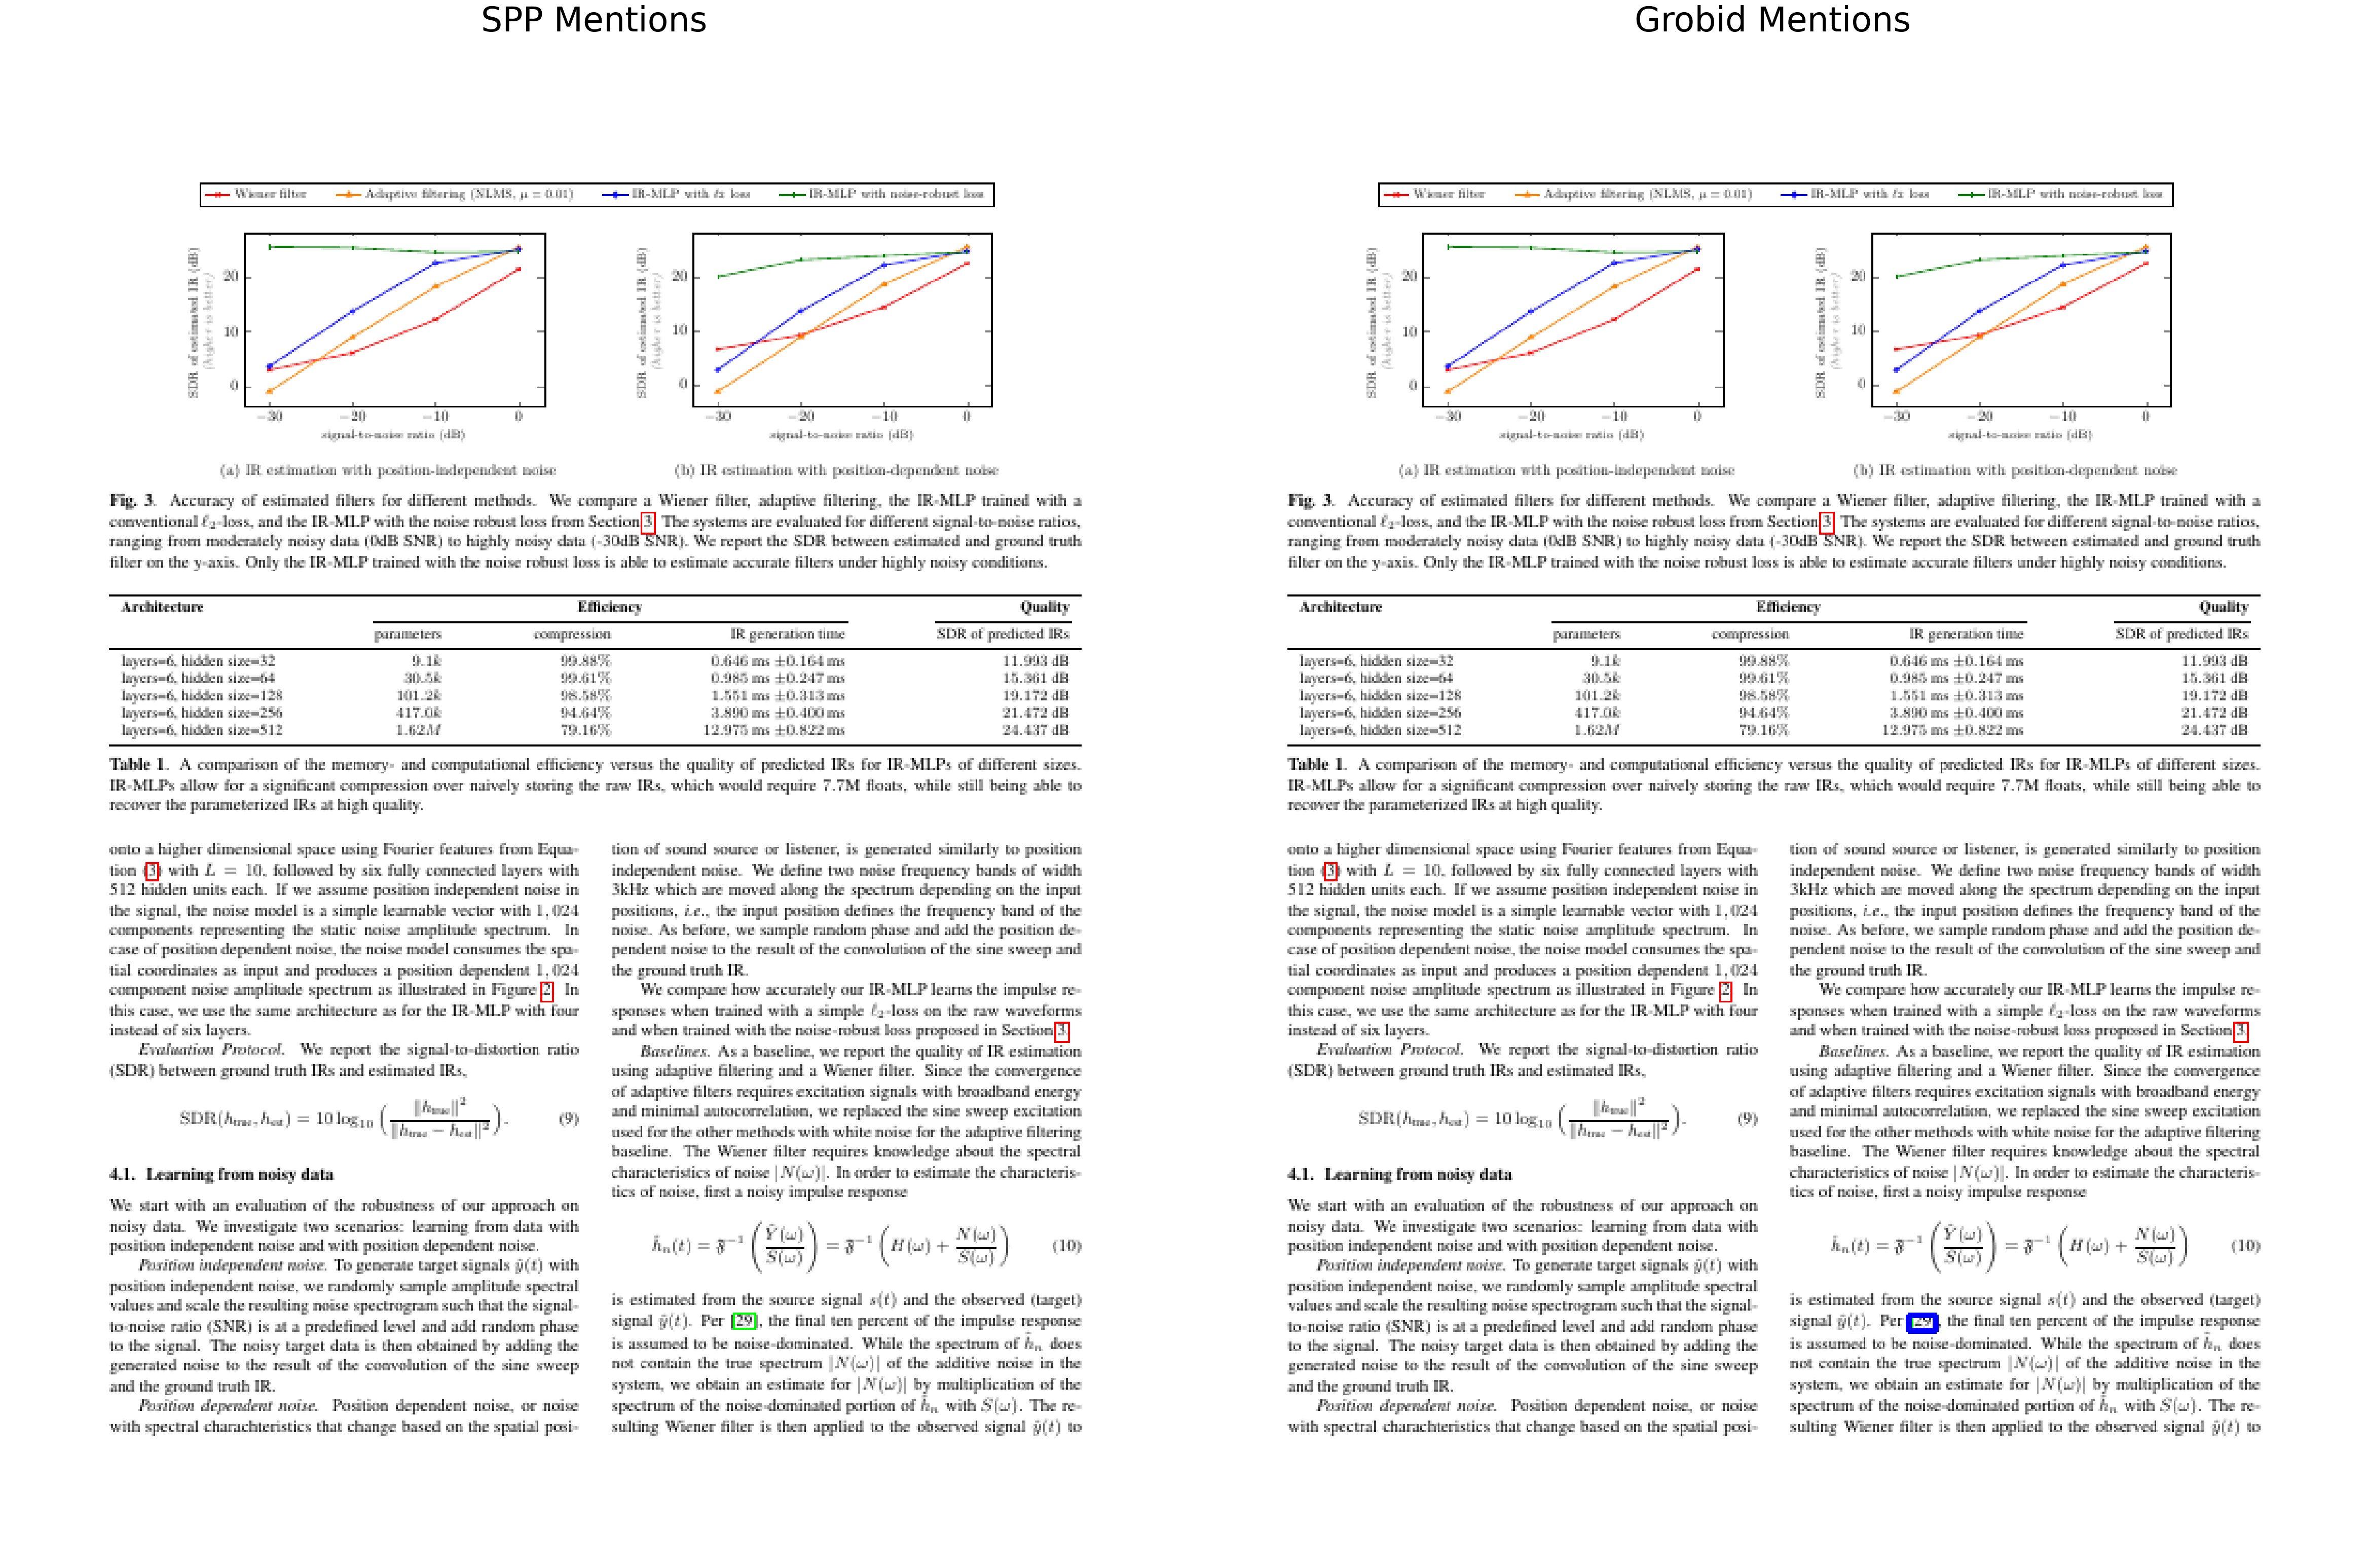

In [22]:
import cv2
from matplotlib import pyplot as plt

rows = 1
columns = 2
fontsize = 48

#spp
#make boxes and save as image
dic_boxgroups = make_boxgroups_mentions(mmda_doc)
image1 = draw_boxgroups(mmda_doc.images[annot_page], list(dic_boxgroups[1]))

#plot
fig = plt.figure(figsize=(60, 60))
fig.add_subplot(rows, columns, 1)
plt.axis('off')
plt.title("SPP Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image1)


#grobid
#make boxes and save as image
boxgroups = make_boxgroup_mentions_from_grobid(grobid_annotation)
image2 = draw_boxgroups(mmda_doc.images[annot_page], list(boxgroups[annot_page+1]))

#plot side by side
fig.add_subplot(rows, columns, 2)
plt.axis('off')
plt.title("Grobid Mentions",fontdict={'fontsize': fontsize})
plt.imshow(image2)
plt.subplots_adjust(wspace=0, hspace=0)